In [31]:
import numpy as np
import pandas as pd

In [32]:
dataset_dir = "datasets"

train_file = 'news_traindata'
train_nrows = 110000 * 0.9
train_df = pd.read_csv(f'{dataset_dir}/{train_file}.csv', encoding='utf-8', nrows=train_nrows)
train_df = train_df.dropna()

test_file = 'news_testdata'
test_nrows = 110000 * 0.1
test_df = pd.read_csv(f'{dataset_dir}/{test_file}.csv', encoding='utf-8', nrows=test_nrows)
test_df = test_df.dropna()

vocab_file = f'vocabs/vokab_{train_file}_{train_nrows}.pkl'
model_file = f"models/secondary_model_{train_file}_{train_nrows}.pth"
encoded_testfile = f"encoded/secondary_{test_file}_{test_nrows}.pt"
encoded_trainfile = f"encoded/secondary_{train_file}_{train_nrows}.pt"
label_encoding_file = f"encoded/secondary_label_encoding_{train_file}_{train_nrows}.pkl"

In [33]:
train_df['content'] = train_df['title'].fillna('') + ' ' + train_df['content'].fillna('')
test_df['content'] = test_df['title'].fillna('') + ' ' + test_df['content'].fillna('')

In [34]:
import os
import pickle
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from collections import Counter

MAX_VOCAB = 25000
special_tokens = ['<unk>', '<pad>']
tokenizer = get_tokenizer('basic_english')


if os.path.exists(vocab_file):
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    print("Vocabulary loaded from 'vocab.pkl'.")

else:
    print("Vocab not found: ", vocab_file)


Vocabulary loaded from 'vocab.pkl'.


In [35]:
train_df = train_df[train_df['label'] == 1]
test_df = test_df[test_df['label'] == 1]

In [36]:
import torch
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

MAX_LENGTH = 4096

if os.path.exists(label_encoding_file):
    with open(label_encoding_file, 'rb') as f:
        le = pickle.load(f)
    print(f"Label encoder loaded from {label_encoding_file}.")
else:
    print(f"Label encoder not found: {label_encoding_file}.")

train_df['type_encoded'] = le.transform(train_df['type'])
test_df['type_encoded'] = le.transform(test_df['type'])
NUM_CLASSES = len(le.classes_)

if os.path.exists(encoded_testfile):
    data = torch.load(encoded_testfile)
    test_encoded_texts = data['inputs']
    test_labels = data['labels']
else:
    print("Encoded file not found: ", encoded_testfile)

Label encoder loaded from encoded/secondary_label_encoding_news_traindata_99000.0.pkl.


In [37]:
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


val_ds = NewsDataset(test_encoded_texts[:500], test_labels[:500])
val_dl = DataLoader(val_ds, batch_size=32, num_workers=0)

In [38]:
from mulstage_model import CNN_BiLSTM
from torch import nn


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
model = CNN_BiLSTM(vocab=vocab, vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=NUM_CLASSES, pad_idx=vocab['<pad>'])
model.to(device)

print("done constructing model")

model.load_state_dict(torch.load(model_file))


Using device: mps
done constructing model


<All keys matched successfully>

In [39]:
def evaluate(model, loader):
    model.eval()
    total_acc = 0

    pred_list = []
    actual_list = []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            preds_class = preds.argmax(dim=1)
            labels_class = yb.argmax(dim=1)
            pred_list.append(preds_class.cpu().numpy())
            actual_list.append(labels_class.cpu().numpy())
            total_acc += (preds_class == labels_class).float().mean().item()
    
    return total_acc / len(loader), np.concatenate(pred_list), np.concatenate(actual_list)


eval, pred, actual = evaluate(model, val_dl)
print(f"evaluation accuracy: {eval:.4f}")

evaluation accuracy: 0.8406


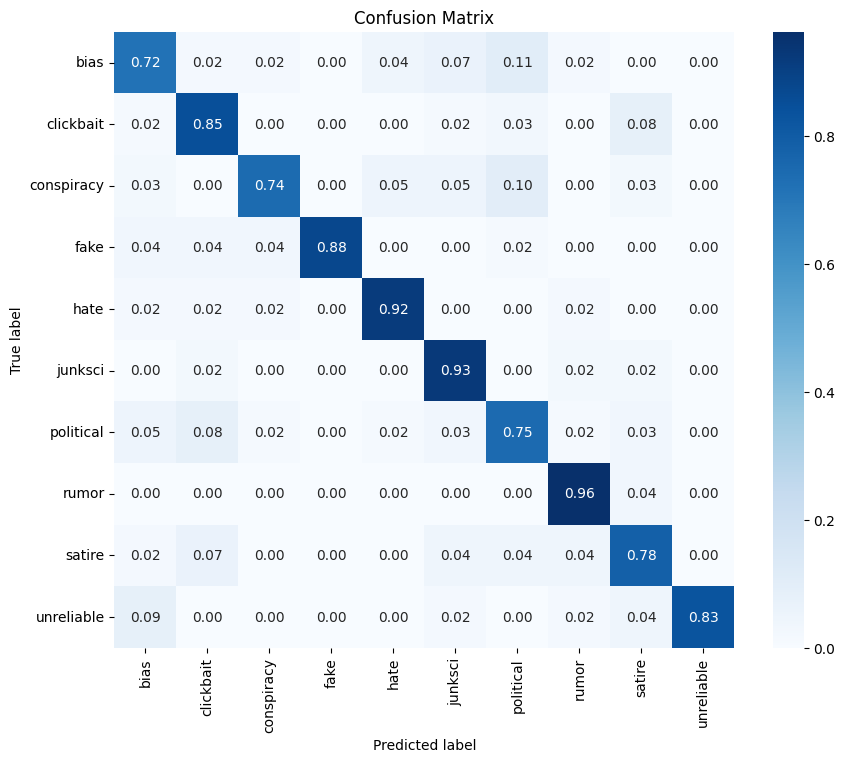

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False):
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    # plt.savefig('secondary_model_confusion_matrix.png')


plot_confusion_matrix(actual, pred, classes=le.classes_, normalize=True)